# Sentiment Analysis on Movie Reviews with Logistic Regression
This Nodebook is meaned to practice what I have learned in  the cousera specialisation NLP, I Intend on using the tools I got from there, not to use the best/newest tools.<br>
it is notable that in the course, we were only made to differenciate between positive and negative not form 0 to 4.


# Imports

In [250]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import string

from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import word_tokenize  # in the course a tweet tokenizer was used

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


# data preparation

In [251]:
train = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t', index_col="PhraseId")
test = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t', index_col="PhraseId")


In [252]:
test.head()

,SentenceId,Phrase
PhraseId,,
156061,8545,An intermittently pleasing but mostly routine ...
156062,8545,An intermittently pleasing but mostly routine ...
156063,8545,An
156064,8545,intermittently pleasing but mostly routine effort
156065,8545,intermittently pleasing but mostly routine


<BarContainer object of 5 artists>

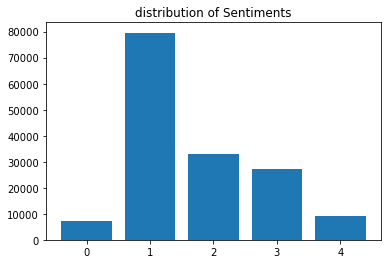

In [253]:
plt.title("distribution of Sentiments")
plt.bar(train.Sentiment.unique(),train.Sentiment.value_counts())

I am not sure if I want to keep the SentenceID or if should kick them. The closest to the Assignment would probably be just looking at the sentences.

In [254]:
train.drop("SentenceId", axis=1,inplace=True)
test.drop("SentenceId", axis=1,inplace=True)
train.head()

,Phrase,Sentiment
PhraseId,,
1,A series of escapades demonstrating the adage ...,1
2,A series of escapades demonstrating the adage ...,2
3,A series,2
4,A,2
5,series,2


In [255]:
test.head()

,Phrase
PhraseId,
156061,An intermittently pleasing but mostly routine ...
156062,An intermittently pleasing but mostly routine ...
156063,An
156064,intermittently pleasing but mostly routine effort
156065,intermittently pleasing but mostly routine


In [256]:
trainY=train.pop("Sentiment")
list(trainY)
trainY[:5]

PhraseId
1    1
2    2
3    2
4    2
5    2
Name: Sentiment, dtype: int64

In [257]:
train=train.values.tolist()
test=test.values.tolist()
#flatten the lists
train = [item for sublist in train for item in sublist]
test = [item for sublist in test for item in sublist]
test[:5]

['An intermittently pleasing but mostly routine effort .',
 'An intermittently pleasing but mostly routine effort',
 'An',
 'intermittently pleasing but mostly routine effort',
 'intermittently pleasing but mostly routine']

# Preprocessing / preparation
I will make a dictionary showing how many times a word was used in a scntence of a certain sentiment

In [258]:
stopwords_english = stopwords.words('english') 

In [259]:
def process_text(text):
    token = word_tokenize(text)
    clean = []
    
    for word in token: # Go through every word in your tokens list
        if (word not in stopwords_english and  word not in string.punctuation):  
            clean.append(word)
    
    return clean

In [260]:
def build_freqs(texts, sentiments):
    
    yslist = np.squeeze(sentiments).tolist()
    
    freqs = {}
    for y, text in zip(yslist, texts):
        for word in process_text(text):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
    
    return freqs

In [261]:
freqDict = build_freqs(train, trainY)
freqDict

{('A', 1): 449,
 ('series', 1): 84,
 ('escapades', 1): 1,
 ('demonstrating', 1): 4,
 ('adage', 1): 2,
 ('good', 1): 309,
 ('goose', 1): 2,
 ('also', 1): 105,
 ('gander', 1): 2,
 ('occasionally', 1): 31,
 ('amuses', 1): 2,
 ('none', 1): 66,
 ('amounts', 1): 24,
 ('much', 1): 589,
 ('story', 1): 508,
 ('A', 2): 604,
 ('series', 2): 168,
 ('escapades', 2): 4,
 ('demonstrating', 2): 8,
 ('adage', 2): 11,
 ('good', 2): 446,
 ('goose', 2): 19,
 ('good', 3): 845,
 ('goose', 3): 4,
 ('also', 2): 169,
 ('gander', 2): 7,
 ('occasionally', 2): 63,
 ('amuses', 2): 7,
 ('none', 2): 54,
 ('amounts', 2): 12,
 ('much', 2): 683,
 ('story', 2): 900,
 ('amuses', 3): 1,
 ('This', 4): 65,
 ('quiet', 4): 20,
 ('introspective', 4): 2,
 ('entertaining', 4): 168,
 ('independent', 4): 2,
 ('worth', 4): 76,
 ('seeking', 4): 4,
 ('This', 3): 140,
 ('quiet', 3): 51,
 ('introspective', 3): 11,
 ('entertaining', 3): 265,
 ('independent', 3): 9,
 ('This', 2): 188,
 ('quiet', 2): 40,
 ('introspective', 2): 4,
 ('indep

# model

In [262]:
train=np.array(train)
test=np.array(test)

In [263]:
def sigmoid(z): # could have imported
    h = 1/(1+np.exp(-z))
    return h

In [264]:
def LogReg(x, y, theta, alpha, num_iters): # log regression

    m = x.shape[0]

    for i in range(0, num_iters):
        
        z = x.dot(theta)
        
        h = sigmoid(z)
        
        J = np.dot(-1./m,    (y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h))) )

        theta = theta - np.dot(alpha/m, (x.T.dot(h-y)))

    J = float(J)
    return J, theta

In [265]:
def extract_features(text, freqs):# creating veaturevectors

    word_l = process_text(text)
    

    x = np.zeros((1, 6)) # 6=5 sentiments + bias
    
    x[0,0] = 1
    
    for word in word_l:

        if (word, 0) in freqs:
            x[0,1] += freqs[(word, 0.0)]
        if (word, 1) in freqs:
            x[0,2] += freqs[(word, 1.0)]
        if (word, 2) in freqs:
            x[0,3] += freqs[(word, 2.0)]
        if (word, 3) in freqs:
            x[0,4] += freqs[(word, 3.0)]
        if (word, 4) in freqs:
            x[0,5] += freqs[(word, 4.0)]

    return x

In [266]:
extract_features(train[0], freqDict)

array([[1.000e+00, 7.740e+02, 2.487e+03, 3.601e+03, 3.967e+03, 1.565e+03]])

In [267]:
trainNew=np.zeros((len(train), 6))
testNew=np.zeros((len(test), 6))

for i in range(len(train)):
    trainNew[i, :]= extract_features(train[i], freqDict)

for i in range(len(test)):
    testNew[i, :]= extract_features(test[i], freqDict)

In [ ]:
cost, theta = LogReg(trainNew, trainY, np.random.random_sample((6,1)), 0.5, 1)
print(cost)
cost, theta = LogReg(trainNew, trainY, theta, 0.02, 100)
print(cost)
cost, theta = LogReg(trainNew, trainY, theta, 1e-8, 200)
print(cost, theta)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
